In [29]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt, seaborn as sns
from sentence_transformers import SentenceTransformer, util 

In [30]:
path = "../processed/train/paraphrased/paraphrase_humarin_samples_62_02_12_23.csv"
df = pd.read_csv(path)

In [3]:
def generate_similarity_matrix(df, model, row=None):
    if row == None:
        row = np.random.randint(0, df.shape[0])
    id = df["id"][row]
    base_kgw_wm = df["content"][row]
    kgw_pp = [df[f"pp-kgw-{i}"][row] for i in range(1,4)]
    sentences = [base_kgw_wm] + kgw_pp

    embeddings = model.encode(sentences, convert_to_tensor=True)
    cosine_scores = util.cos_sim(embeddings, embeddings).cpu()
    return id, cosine_scores

In [39]:
def plot_image(cosine_scores, save=False, save_location=None):
    labels = ["base", "pp-1", "pp-2", "pp-3"]
    
    ax = sns.heatmap(mu, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
    ax.set_ylabel("Text Group")
    ax.set_xlabel("Text Group")
    ax.set_title("Sentence Similarity between Recursive Paraphrases")
    
    if save:
        if save_location == None:
            raise "Save location must be defined if saving"
        plt.savefig(save_location)
    plt.show()

In [40]:
def plot_image2(cosine_scores, save=False, save_location = None):
    fig, ax = plt.subplots()
    cax = ax.matshow(cosine_scores.cpu(), cmap='plasma', vmin=0, vmax=1)
    fig.colorbar(cax)
    
    labels = ["base", "pp-1", "pp-2", "pp-3"]
    
    ax.set_xticklabels(['']+labels)
    ax.set_yticklabels(['']+labels)
    for (i, j), z in np.ndenumerate(cosine_scores):
        ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')

    ax.set_title("Sentence Similarity between recursive paraphrases")
    if save:
        if save_location == None:
            raise "Save location must be defined if saving"
        plt.savefig(save_location)
    plt.show()

In [41]:
model = SentenceTransformer("all-MiniLM-L6-v2")

## 10 Sample Sentence Similarity Matrices

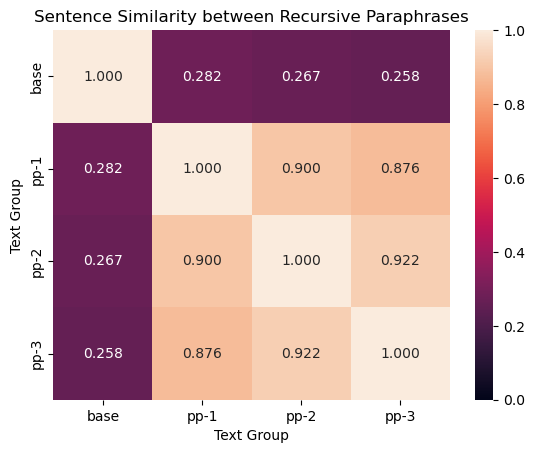

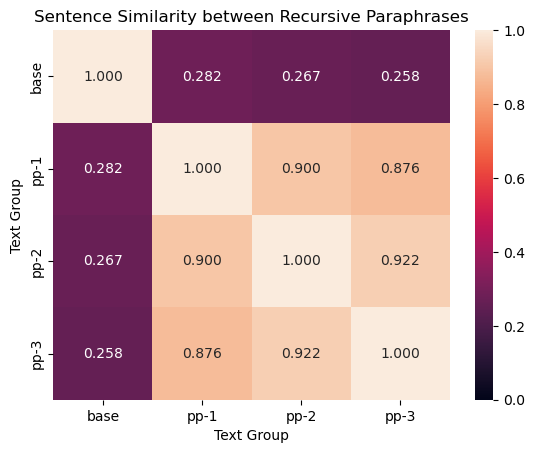

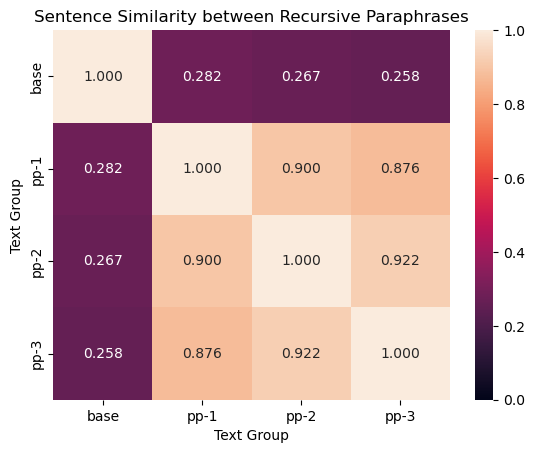

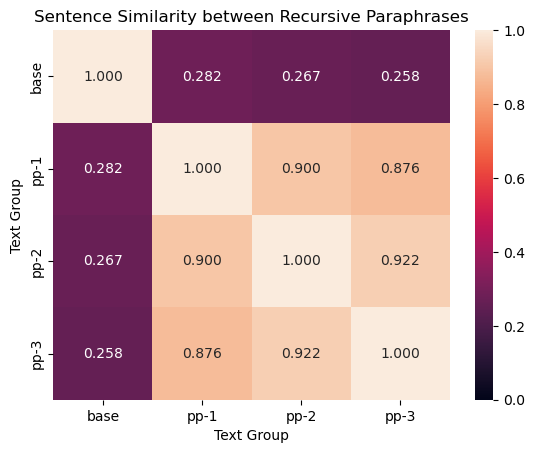

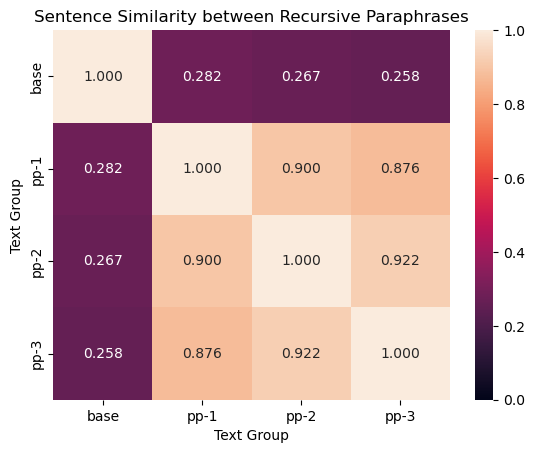

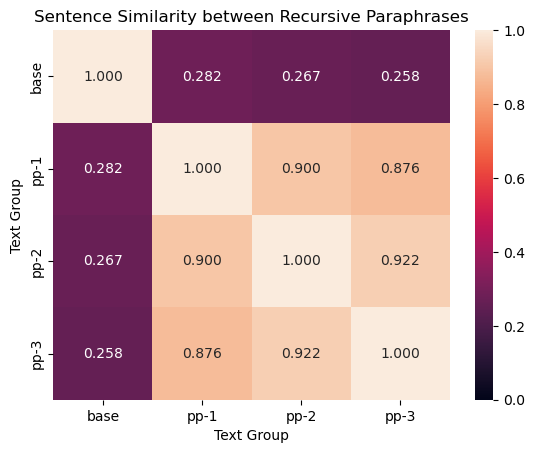

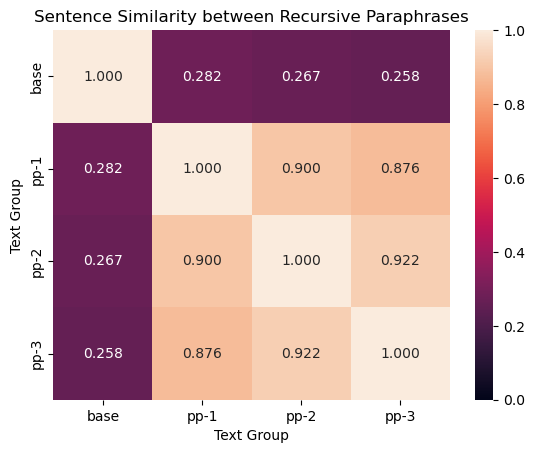

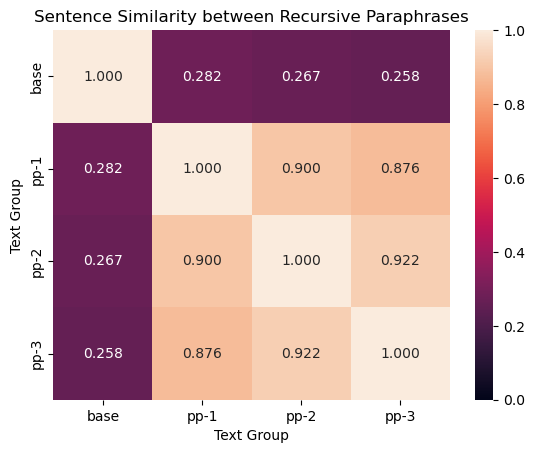

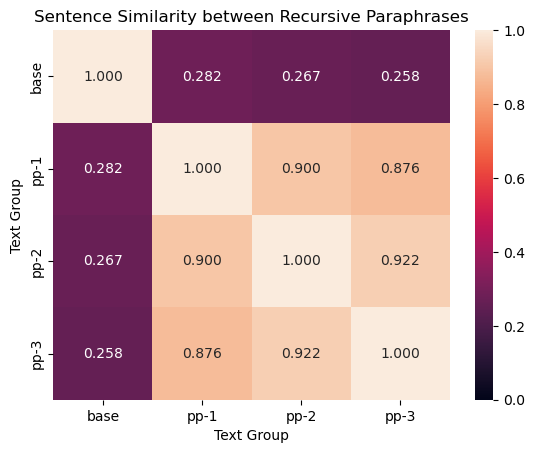

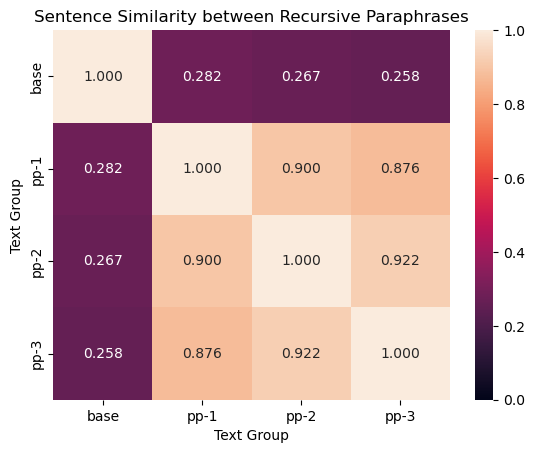

In [44]:
base_path = "../results/images/sentence_similarity/gpt-2-december/"
for i in range(10):
    id, cosine_scores = generate_similarity_matrix(df, model)
    save_location = base_path + f"article_{id}.png"
    plot_image(cosine_scores, save=False, save_location=save_location)

## Mean Sentence Similarity over 60 documents

In [46]:
no_sentences = 4
all_cosine_scores = np.zeros(shape=(df.shape[0], no_sentences, no_sentences))
for i in range(df.shape[0]):
    _, cosine_score = generate_similarity_matrix(df, model, row=i)
    all_cosine_scores[i] = cosine_score
mu = np.mean(all_cosine_scores, axis=0)
sigma = np.std(all_cosine_scores, axis=0)

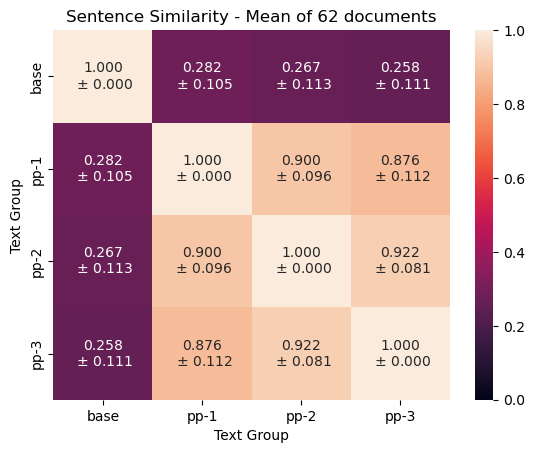

In [49]:
annotation = np.empty(shape=mu.shape, dtype='object')
labels = ["base", "pp-1", "pp-2", "pp-3"]
for (i, j), val in np.ndenumerate(sigma):
    mu_value = mu[i][j]
    annotation[i][j] = f"{mu_value:0.3f}\n $\pm$ {val:.3f}"
    
ax = sns.heatmap(mu, annot=annotation, fmt='', xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
ax.set_ylabel("Text Group")
ax.set_xlabel("Text Group")
ax.set_title(f"Sentence Similarity - Mean of {df.shape[0]} documents")

plt.savefig(base_path+"mean_62_documents.png")
plt.show()